# **Part A** 

In [17]:
# ======================== TEST SCRIPT ========================

import os
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image

# ================= CONFIGURATION =================
# ⚠️ UPDATE THIS PATH to the folder containing your test images
TEST_IMAGES_FOLDER = 'Test Cases Structure/Integerated Test' 

MODEL_PATH = 'Models/part_a_best_mobilenet.pth'
OUTPUT_FILE = 'classification_results.txt'
IMG_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ================= MODEL CLASS DEFINITION =================
# We must redefine the class exactly as it was during training to load weights correctly
class FoodFruitClassifier(nn.Module):
    def __init__(self, pretrained=False):
        super(FoodFruitClassifier, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=pretrained)
        num_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier[1] = nn.Linear(num_features, 2)
    
    def forward(self, x):
        return self.mobilenet(x)

# ================= PREPROCESSING =================
# Must match the Validation Transform from Part A
inference_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_image(image_path, model):
    try:
        # Open image using PIL (Standard for PyTorch)
        image = Image.open(image_path).convert('RGB')
        
        # Apply transforms and add batch dimension (1, C, H, W)
        image_tensor = inference_transform(image).unsqueeze(0)
        image_tensor = image_tensor.to(DEVICE)
        
        with torch.no_grad():
            outputs = model(image_tensor)
            _, predicted = torch.max(outputs, 1)
            
            # Get confidence score (optional)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            confidence = probs[0][predicted.item()].item()
            
        return predicted.item(), confidence
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, 0.0

# ================= MAIN EXECUTION =================
def run_test():
    print("=" * 60)
    print("🚀 STARTING INFERENCE TEST")
    print(f"📂 Reading images from: {TEST_IMAGES_FOLDER}")
    print(f"💾 Saving results to: {OUTPUT_FILE}")
    print("=" * 60)

    # 1. Load the Model
    if not os.path.exists(MODEL_PATH):
        print(f"❌ Model file not found at {MODEL_PATH}. Please run Part A training first.")
        return

    print("Loading model weights...")
    model = FoodFruitClassifier(pretrained=False) # Pretrained=False because we are loading custom weights
    
    # Load the checkpoint dictionary
    checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    model.to(DEVICE)
    model.eval()
    print("✅ Model loaded successfully.")

    # 2. Check Input Folder
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
    if not os.path.exists(TEST_IMAGES_FOLDER):
         print(f"❌ Test folder '{TEST_IMAGES_FOLDER}' does not exist.")
         return

    image_files = [f for f in os.listdir(TEST_IMAGES_FOLDER) if f.lower().endswith(valid_extensions)]
    
    if not image_files:
        print("❌ No images found in the test folder.")
        return

    print(f"Found {len(image_files)} images. Processing...")
    print("-" * 60)

    # 3. Process Images and Write to File
    with open(OUTPUT_FILE, 'w') as f:
        # Write Header
        f.write("Image_Name | Predicted_Class | Action\n")
        f.write("-" * 50 + "\n")
        
        for img_name in sorted(image_files):
            img_path = os.path.join(TEST_IMAGES_FOLDER, img_name)
            
            # Predict
            pred_idx, conf = predict_image(img_path, model)
            
            if pred_idx is None:
                continue

            # MAPPING: 0 = Food, 1 = Fruit
            # LOGIC: If Food -> Part B. If Fruit -> Part C.
            
            if pred_idx == 0:
                result_label = "Food"
                action = "Go to Part B"
            else:
                result_label = "Fruit"
                action = "Go to Part C"
            
            # Formatting output string
            output_line = f"{img_name} | {result_label} | {action}"
            
            # Print to Console
            print(f"🖼️ {img_name:<20} : {result_label:<6} ({conf*100:.1f}%) -> {action}")
            
            # Write to Text File
            f.write(output_line + "\n")

    print("=" * 60)
    print(f"✅ Testing Finished. Check '{OUTPUT_FILE}' for records.")

if __name__ == "__main__":
    run_test()

🚀 STARTING INFERENCE TEST
📂 Reading images from: Test Cases Structure/Integerated Test
💾 Saving results to: classification_results.txt
Loading model weights...


c:\Users\Toka Khaled\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Toka Khaled\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Model loaded successfully.
Found 3 images. Processing...
------------------------------------------------------------
🖼️ 2371108_112g.jpg     : Food   (100.0%) -> Go to Part B
🖼️ 902277_120g.jpg      : Food   (99.8%) -> Go to Part B
🖼️ img1_100g.jpg        : Fruit  (99.9%) -> Go to Part C
✅ Testing Finished. Check 'classification_results.txt' for records.


# **Part B** 

## **Case 1**

In [18]:
# ============================================================================
# CASE 1: Recognize Food Type from Training Categories
# ============================================================================

import os
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input

# ============================================================================
# Configuration
# ============================================================================
IMG_SIZE = (300, 300)
TRAIN_DIR = "Project Data/Food/Train"  # Training data folder
TEST_DIR_CASE1 = "case1"    # Test images folder
MODEL_PATH = "Models/food_encoder_model_triplet_80%val.h5"

# ============================================================================
# Load Siamese Model
# ============================================================================
print("Loading trained Siamese model...")
encoder = load_model(MODEL_PATH)
print("✓ Model loaded successfully!")

# ============================================================================
# Helper Functions
# ============================================================================

def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=IMG_SIZE)
    img = img_to_array(img)
    img = preprocess_input(np.expand_dims(img, axis=0))
    return img

def get_embedding(img_path):
    img = load_and_preprocess_image(img_path)
    embedding = encoder.predict(img, verbose=0)
    return embedding[0]

def compute_distance(embedding1, embedding2):
    return np.sqrt(np.sum(np.square(embedding1 - embedding2)))

# ============================================================================
# Load Training Class Representatives
# ============================================================================
def load_class_representatives(train_dir, samples_per_class=3):
    """Load embeddings from representative images of each training class"""
    class_embeddings = {}
    for cls in os.listdir(train_dir):
        cls_path = os.path.join(train_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        images = glob(os.path.join(cls_path, "*.jpg")) + glob(os.path.join(cls_path, "*.png")) + glob(os.path.join(cls_path, "*.jpeg"))
        sample_images = images[:samples_per_class]
        embeddings = [get_embedding(img) for img in sample_images if os.path.isfile(img)]
        if embeddings:
            class_embeddings[cls] = embeddings
            print(f"  ✓ {cls}: {len(embeddings)} samples loaded")
    return class_embeddings

# ============================================================================
# Recognize Food Class for Test Images
# ============================================================================
def recognize_food_from_training(test_image_path, class_embeddings):
    """Predict class of a single test image by comparing to training categories"""
    test_emb = get_embedding(test_image_path)
    class_distances = {cls: np.mean([compute_distance(test_emb, emb) for emb in embs]) 
                       for cls, embs in class_embeddings.items()}
    predicted_class = min(class_distances, key=class_distances.get)
    confidence = class_distances[predicted_class]
    return predicted_class, confidence, class_distances

def test_case_1(test_dir, class_embeddings, output_file="case1_results.txt"):
    print("\n" + "="*80)
    print("CASE 1: Food Recognition from Training Categories")
    print("="*80)

    test_images = glob(os.path.join(test_dir, "*.*"))
    results = []

    with open(output_file, "w", encoding="utf-8") as f:
        f.write("CASE 1: Food Recognition from Training Categories\n")
        f.write("="*80 + "\n")

        for img_path in test_images:
            predicted_class, confidence, _ = recognize_food_from_training(
                img_path, class_embeddings
            )

            line = f"{os.path.basename(img_path)} | Predicted: {predicted_class} | Distance: {confidence:.4f}"
            print(line)

            f.write(line + "\n")
            results.append((img_path, predicted_class, confidence))

    print(f"\n✓ Results saved to: {output_file}")
    return results


# ============================================================================
# Execute Case 1
# ============================================================================
class_embeddings = load_class_representatives(TRAIN_DIR, samples_per_class=3)
case1_results = test_case_1(TEST_DIR_CASE1, class_embeddings)


Loading trained Siamese model...


✓ Model loaded successfully!
  ✓ apple_pie: 3 samples loaded
  ✓ baby_back_ribs: 3 samples loaded
  ✓ baklava: 3 samples loaded
  ✓ beef_carpaccio: 3 samples loaded
  ✓ beef_tartare: 3 samples loaded
  ✓ beet_salad: 3 samples loaded
  ✓ beignets: 3 samples loaded
  ✓ bibimbap: 3 samples loaded
  ✓ bread_pudding: 3 samples loaded
  ✓ breakfast_burrito: 3 samples loaded
  ✓ caesar_salad: 3 samples loaded
  ✓ cannoli: 3 samples loaded
  ✓ caprese_salad: 3 samples loaded
  ✓ carrot_cake: 3 samples loaded
  ✓ cheesecake: 3 samples loaded
  ✓ cheese_plate: 3 samples loaded
  ✓ chicken_curry: 3 samples loaded
  ✓ chicken_quesadilla: 3 samples loaded
  ✓ chicken_wings: 3 samples loaded
  ✓ chocolate_cake: 3 samples loaded
  ✓ chocolate_mousse: 3 samples loaded
  ✓ churros: 3 samples loaded
  ✓ clam_chowder: 3 samples loaded
  ✓ club_sandwich: 3 samples loaded
  ✓ croque_madame: 3 samples loaded
  ✓ cup_cakes: 3 samples loaded
  ✓ deviled_eggs: 3 samples loaded
  ✓ donuts: 3 samples loaded
  ✓ 

## **Case 2**

In [19]:
# ============================================================================
# Siamese Case II: Anchor vs Reference Images (Fixed)
# ============================================================================

import os
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input

# ============================================================================
# Configuration
# ============================================================================
IMG_SIZE = (300, 300)
SIMILARITY_THRESHOLD = 1.0  # Distance below this means "similar"
TEST_DIR = "Test Cases Structure/Siamese Case II Test"  # Folder containing Anchor + reference images
MODEL_PATH = "Models/food_encoder_model_triplet_80%val.h5"

# ============================================================================
# Load Trained Model
# ============================================================================
print("Loading trained Siamese model...")
encoder = load_model(MODEL_PATH)
print("✓ Model loaded successfully!")

# ============================================================================
# Helper Functions
# ============================================================================

def load_and_preprocess_image(img_path):
    """Load and preprocess a single image"""
    img = load_img(img_path, target_size=IMG_SIZE)
    img = img_to_array(img)
    img = preprocess_input(np.expand_dims(img, axis=0))
    return img

def get_embedding(img_path):
    """Get the embedding vector for an image"""
    img = load_and_preprocess_image(img_path)
    embedding = encoder.predict(img, verbose=0)
    return embedding[0]

def compute_distance(embedding1, embedding2):
    """Compute Euclidean distance between two embeddings"""
    return np.sqrt(np.sum(np.square(embedding1 - embedding2)))

# ============================================================================
# Main Test Function
# ============================================================================

def find_most_similar(anchor_path, test_dir, threshold=SIMILARITY_THRESHOLD):
    """Compare anchor image to all reference images in folder"""
    
    # Load anchor embedding
    anchor_emb = get_embedding(anchor_path)
    
    # Exclude the anchor itself (case-insensitive)
    anchor_name_lower = os.path.basename(anchor_path).lower()
    reference_images = [f for f in glob(os.path.join(test_dir, "*"))
                        if os.path.isfile(f) and os.path.basename(f).lower() != anchor_name_lower]
    
    if not reference_images:
        print("No reference images found!")
        return None
    
    distances = {}
    for ref_img in reference_images:
        ref_emb = get_embedding(ref_img)
        dist = compute_distance(anchor_emb, ref_emb)
        distances[ref_img] = dist
        print(f"Distance from Anchor to {os.path.basename(ref_img)}: {dist:.4f}")
    
    # Find closest reference image
    closest_image = min(distances, key=distances.get)
    closest_distance = distances[closest_image]
    
    if closest_distance <= threshold:
        print(f"\nMost similar image: {os.path.basename(closest_image)} (Distance: {closest_distance:.4f})")
    else:
        print("\nNo match found (all distances above threshold).")
    
    return closest_image, closest_distance

# ============================================================================
# Execute Test
# ============================================================================

ANCHOR_IMAGE = os.path.join(TEST_DIR, "Anchor.JPG")  # adjust extension if needed
find_most_similar(ANCHOR_IMAGE, TEST_DIR)


Loading trained Siamese model...


✓ Model loaded successfully!
Distance from Anchor to Apple_scap.JPG: 1.0085
Distance from Anchor to Blueberry_healthy.JPG: 1.0999
Distance from Anchor to Blueberry_healthy2.JPG: 1.0382
Distance from Anchor to Hibisicus_plant_gudhal.png: 1.0932
Distance from Anchor to Orange_Citrus_greening.JPG: 1.0293
Distance from Anchor to Peach_Bacterial_spot.JPG: 0.9900
Distance from Anchor to Potato_healthy.JPG: 1.0323
Distance from Anchor to Potato_late_blight.JPG: 0.9843
Distance from Anchor to Rasperry_healthy.JPG: 1.0874
Distance from Anchor to Soybean_healthy.JPG: 0.9692
Distance from Anchor to Squash_Powdery_Mildew.JPG: 1.0789
Distance from Anchor to Tomato_target_spot.JPG: 1.0225

Most similar image: Soybean_healthy.JPG (Distance: 0.9692)


('Test Cases Structure/Siamese Case II Test\\Soybean_healthy.JPG', 0.9692322)

In [20]:
# ============================================================================
# Siamese Case II: Anchor vs Reference Images (CLIP Version)
# ============================================================================

import os
import numpy as np
from glob import glob
from PIL import Image
import torch
import open_clip

# ============================================================================
# Configuration
# ============================================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

TEST_DIR = "Test Cases Structure/Siamese Case II Test"
ANCHOR_IMAGE = os.path.join(TEST_DIR, "Anchor.JPG")

SIMILARITY_THRESHOLD = 0.3  # Cosine similarity threshold
FINETUNED_MODEL_PATH = "Models/clip_finetuned_5_Shots.pth"

# ============================================================================
# Load Fine-Tuned CLIP Model
# ============================================================================
print("Loading fine-tuned CLIP model...")

clip_model, _, preprocess = open_clip.create_model_and_transforms(
    model_name="ViT-B-32",
    pretrained="openai"
)

checkpoint = torch.load(FINETUNED_MODEL_PATH, map_location=DEVICE)
clip_model.load_state_dict(checkpoint["clip_model_state_dict"])

clip_model = clip_model.to(DEVICE).eval()
print("✓ CLIP model loaded successfully!")

# ============================================================================
# Helper Functions
# ============================================================================

def load_and_preprocess_image(img_path):
    """Load and preprocess image for CLIP"""
    img = Image.open(img_path).convert("RGB")
    return preprocess(img).unsqueeze(0).to(DEVICE)

def get_embedding(img_path):
    """Get normalized CLIP embedding"""
    image = load_and_preprocess_image(img_path)
    with torch.no_grad():
        emb = clip_model.encode_image(image)
    emb = emb / emb.norm(dim=-1, keepdim=True)
    return emb.cpu().numpy()[0]

def compute_similarity(emb1, emb2):
    """Cosine similarity"""
    return np.dot(emb1, emb2)

# ============================================================================
# Main Test Function (Siamese Style)
# ============================================================================

def find_most_similar(anchor_path, test_dir, threshold=SIMILARITY_THRESHOLD):
    print("\n" + "=" * 80)
    print("SIAMESE CASE II (CLIP): Anchor vs Reference Images")
    print("=" * 80)

    # Anchor embedding
    anchor_emb = get_embedding(anchor_path)

    # Exclude anchor itself
    anchor_name = os.path.basename(anchor_path).lower()
    reference_images = [
        f for f in glob(os.path.join(test_dir, "*"))
        if os.path.isfile(f) and os.path.basename(f).lower() != anchor_name
    ]

    if not reference_images:
        print("No reference images found!")
        return None

    similarities = {}

    for ref_img in reference_images:
        ref_emb = get_embedding(ref_img)
        sim = compute_similarity(anchor_emb, ref_emb)
        similarities[ref_img] = sim
        print(f"Similarity from Anchor to {os.path.basename(ref_img)}: {sim:.4f}")

    # Best match
    best_image = max(similarities, key=similarities.get)
    best_similarity = similarities[best_image]

    print("\nSUMMARY")
    if best_similarity >= threshold:
        print(f"✓ Most similar image: {os.path.basename(best_image)}")
        print(f"  Similarity: {best_similarity:.4f}")
    else:
        print("✗ No match found (below similarity threshold)")
        print(f"Closest image: {os.path.basename(best_image)}")
        print(f"Similarity: {best_similarity:.4f}")

    return best_image, best_similarity

# ============================================================================
# Execute Test
# ============================================================================
find_most_similar(ANCHOR_IMAGE, TEST_DIR)

Loading fine-tuned CLIP model...
✓ CLIP model loaded successfully!

SIAMESE CASE II (CLIP): Anchor vs Reference Images
Similarity from Anchor to Apple_scap.JPG: 0.6735
Similarity from Anchor to Blueberry_healthy.JPG: 0.6798
Similarity from Anchor to Blueberry_healthy2.JPG: 0.6878
Similarity from Anchor to Hibisicus_plant_gudhal.png: 0.4324
Similarity from Anchor to Orange_Citrus_greening.JPG: 0.6657
Similarity from Anchor to Peach_Bacterial_spot.JPG: 0.7079
Similarity from Anchor to Potato_healthy.JPG: 0.6833
Similarity from Anchor to Potato_late_blight.JPG: 0.7202
Similarity from Anchor to Rasperry_healthy.JPG: 0.6193
Similarity from Anchor to Soybean_healthy.JPG: 0.7222
Similarity from Anchor to Squash_Powdery_Mildew.JPG: 0.4271
Similarity from Anchor to Tomato_target_spot.JPG: 0.6682

SUMMARY
✓ Most similar image: Soybean_healthy.JPG
  Similarity: 0.7222


('Test Cases Structure/Siamese Case II Test\\Soybean_healthy.JPG', 0.72219145)

In [37]:
# ============================================================================
# Siamese Case II: Anchor vs Reference Images (EfficientNetV2S)
# ============================================================================

import os
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.layers import UnitNormalization

# ============================================================================
# Configuration
# ============================================================================
IMG_SIZE = (300, 300)
SIMILARITY_THRESHOLD = 1.0  # Distance below this means "similar"
TEST_DIR = "TestCases/Siamese Case II Test"  # Folder containing Anchor + reference images
MODEL_PATH = "Models/PartB_EfficientNetB2.h5"  # your saved encoder

# ============================================================================
# Load Saved Encoder
# ============================================================================
print("Loading EfficientNetV2S encoder...")
encoder = tf.keras.models.load_model(MODEL_PATH, compile=False)
print("✓ Encoder loaded successfully!")

# ============================================================================
# Helper Functions
# ============================================================================
def load_and_preprocess_image(img_path):
    """Load and preprocess a single image"""
    img = load_img(img_path, target_size=IMG_SIZE)
    img = img_to_array(img)
    img = preprocess_input(np.expand_dims(img, axis=0))
    return img

def get_embedding(img_path):
    """Get the embedding vector for an image"""
    img = load_and_preprocess_image(img_path)
    embedding = encoder.predict(img, verbose=0)
    return embedding[0]

def compute_distance(embedding1, embedding2):
    """Compute Euclidean distance between two embeddings"""
    return np.sqrt(np.sum(np.square(embedding1 - embedding2)))

# ============================================================================
# Main Test Function
# ============================================================================
def find_most_similar(anchor_path, test_dir, threshold=SIMILARITY_THRESHOLD):
    """Compare anchor image to all reference images in folder"""
    
    # Load anchor embedding
    anchor_emb = get_embedding(anchor_path)
    
    # Exclude the anchor itself
    anchor_name_lower = os.path.basename(anchor_path).lower()
    reference_images = [f for f in glob(os.path.join(test_dir, "*"))
                        if os.path.isfile(f) and os.path.basename(f).lower() != anchor_name_lower]
    
    if not reference_images:
        print("No reference images found!")
        return None
    
    distances = {}
    for ref_img in reference_images:
        ref_emb = get_embedding(ref_img)
        dist = compute_distance(anchor_emb, ref_emb)
        distances[ref_img] = dist
        print(f"Distance from Anchor to {os.path.basename(ref_img)}: {dist:.4f}")
    
    # Find closest reference image
    closest_image = min(distances, key=distances.get)
    closest_distance = distances[closest_image]
    
    if closest_distance <= threshold:
        print(f"\nMost similar image: {os.path.basename(closest_image)} (Distance: {closest_distance:.4f})")
    else:
        print("\nNo match found (all distances above threshold).")
    
    return closest_image, closest_distance

# ============================================================================
# Execute Test
# ============================================================================
ANCHOR_IMAGE = os.path.join(TEST_DIR, "Anchor.JPG")  # adjust extension if needed
find_most_similar(ANCHOR_IMAGE, TEST_DIR)


Loading EfficientNetV2S encoder...
✓ Encoder loaded successfully!
Distance from Anchor to eggs_benedict.jpg: 1.4983
Distance from Anchor to foie_grass.jpg: 1.5130
Distance from Anchor to frozen_yogurt.jpg: 1.5234
Distance from Anchor to garlic_bread.jpg: 1.3008
Distance from Anchor to gnocchi.jpg: 1.3560
Distance from Anchor to judd-mat-gardebounen.jpeg: 1.4606
Distance from Anchor to koshari.jpg: 1.4447
Distance from Anchor to lasagna.jpg: 1.4781
Distance from Anchor to mussels.jpg: 1.3823
Distance from Anchor to pad_thai.jpg: 0.9961
Distance from Anchor to pancakes.jpg: 1.5488
Distance from Anchor to Pot au feu.jpg: 1.4229
Distance from Anchor to ramen.jpg: 1.3283
Distance from Anchor to samosa.jpg: 1.5114

Most similar image: pad_thai.jpg (Distance: 0.9961)


('TestCases/Siamese Case II Test\\pad_thai.jpg', 0.99612886)

# **Part C**

In [34]:
# ============================================================
# TEST SCRIPT: FRUIT CLASSIFICATION + CALORIE COMPUTATION (TF)
# ============================================================

import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# -----------------------------
# CONFIG
# -----------------------------
IMG_SIZE = 350

MODEL_PATH = "Models/MobileNetV2_PartC.keras"  
CALORIES_FILE = "Project Data/Fruit/Calories.txt"
TEST_IMAGE_DIR = "testA"

# [NEW] Output file path
OUTPUT_FILE = "test_results.txt" 

# -----------------------------
# LOAD MODEL
# -----------------------------
model = tf.keras.models.load_model(MODEL_PATH)

# -----------------------------
# LOAD CLASS NAMES 
# -----------------------------
TRAIN_DIR = "Project Data/Fruit/Train"

class_names = sorted(
    d for d in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, d))
)

idx_to_class = {i: name for i, name in enumerate(class_names)}

print("Classes:", class_names)

# -----------------------------
# LOAD CALORIES FILE
# -----------------------------
calories_dict = {}

with open(CALORIES_FILE, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue

        match = re.match(r"(.+?):\s*~?([\d.]+)", line)
        if match:
            category = match.group(1).strip()
            cal_per_gram = float(match.group(2))
            calories_dict[category] = cal_per_gram

print("Loaded calories for", len(calories_dict), "classes")

# -----------------------------
# IMAGE PREPROCESSING
# -----------------------------
MEAN = tf.constant([0.485, 0.456, 0.406])
STD  = tf.constant([0.229, 0.224, 0.225])

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img = image.img_to_array(img)
    img = img / 255.0  
    # Note: Ensure this math matches your training exactly. 
    # Usually it is (img - MEAN) / STD. 
    # Your current code does img - (MEAN/STD) due to order of operations.
    img = img - MEAN/STD 
    img = np.expand_dims(img, axis=0)
    return img

# -----------------------------
# HELPER FUNCTIONS
# -----------------------------
def extract_grams(filename):
    match = re.search(r"(\d+)g", filename)
    if not match:
        raise ValueError(f"No gram value found in filename: {filename}")
    return int(match.group(1))


def predict_image(img_path):
    img = preprocess_image(img_path)
    preds = model.predict(img, verbose=0)
    pred_idx = np.argmax(preds, axis=1)[0]
    return idx_to_class[pred_idx]

# -----------------------------
# RUN TESTING
# -----------------------------
print("\n================ TEST RESULTS ================\n")

results = []

for img_name in os.listdir(TEST_IMAGE_DIR):
    if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    img_path = os.path.join(TEST_IMAGE_DIR, img_name)

    # 1. Predict category
    predicted_class = predict_image(img_path)

    # 2. Extract grams
    grams = extract_grams(img_name)

    # 3. Calories lookup
    if predicted_class not in calories_dict:
        # Fallback or raise error
        print(f"Warning: {predicted_class} not found in calories dict.")
        cal_per_gram = 0
    else:
        cal_per_gram = calories_dict[predicted_class]

    # 4. Total calories
    total_calories = grams * cal_per_gram

    results.append({
        "image": img_name,
        "predicted_class": predicted_class,
        "grams": grams,
        "total_calories": round(total_calories, 2)
    })

    print(
        f"{img_name} → {predicted_class} | {grams}g | {total_calories:.2f} kcal"
    )

print("\n================ DONE ================\n")

# -----------------------------
# [NEW] SAVE TO TEXT FILE
# -----------------------------
try:
    with open(OUTPUT_FILE, "w") as f:
        f.write("================ TEST RESULTS ================\n\n")
        
        for res in results:
            line = f"{res['image']} -> {res['predicted_class']} | {res['grams']}g | {res['total_calories']:.2f} kcal\n"
            f.write(line)
            
        f.write(f"\nTotal Images Processed: {len(results)}\n")
        f.write("================ DONE ================\n")
    
    print(f"Successfully saved results to: {os.path.abspath(OUTPUT_FILE)}")

except Exception as e:
    print(f"Error saving file: {e}")

Classes: ['Apple_Gala', 'Apple_Golden Delicious', 'Avocado', 'Banana', 'Berry', 'Burmese Grape', 'Carambola', 'Date Palm', 'Dragon', 'Elephant Apple', 'Grape', 'Green Coconut', 'Guava', 'Hog Plum', 'Kiwi', 'Lichi', 'Malta', 'Mango Golden Queen', 'Mango_Alphonso', 'Mango_Amrapali', 'Mango_Bari', 'Mango_Himsagar', 'Olive', 'Orange', 'Palm', 'Persimmon', 'Pineapple', 'Pomegranate', 'Watermelon', 'White Pear']
Loaded calories for 30 classes

================ TEST RESULTS ================

img1_100g.jpg → Green Coconut | 100g | 190.00 kcal

================ DONE ================

Successfully saved results to: c:\Users\Toka Khaled\Desktop\SC_3\test_results.txt


# **Part D**

Loading model from Models/segnet_best.keras...
Model loaded successfully.
Found 1 images to process.



Saved: predictions/PartD\img1_100g_mask.png


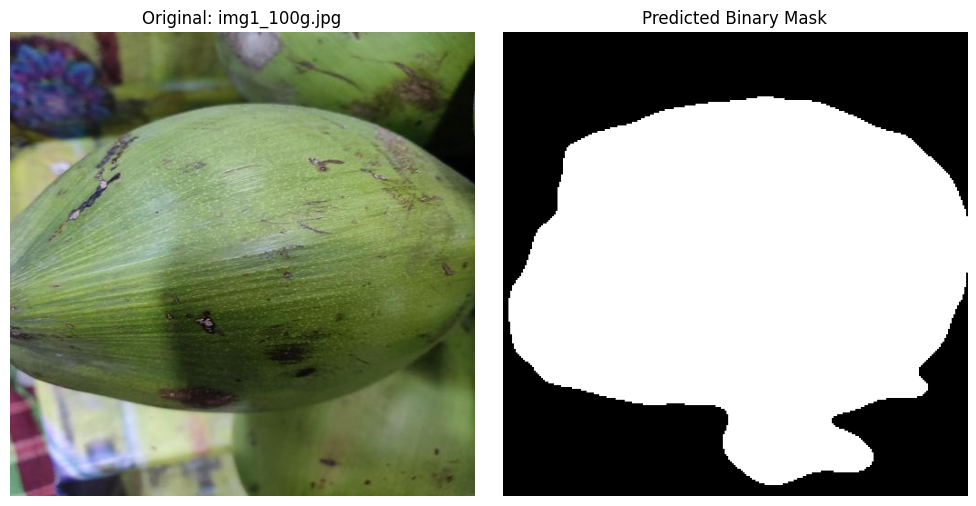


--- Processing Complete ---


In [26]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

# --- 1. Configuration ---
MODEL_PATH = "Models/segnet_best.keras"    
TEST_IMG_DIR = "testA"   
OUTPUT_DIR = "predictions"             
IMAGE_SIZE = (256, 256)                     

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- 2. Load the Model ---
print(f"Loading model from {MODEL_PATH}...")
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
print("Model loaded successfully.")

# --- 3. Processing Function ---

def process_and_visualize(model, img_path, save_dir):
    """
    Loads an image, predicts the mask, saves it, and visualizes the result.
    """
    filename = os.path.basename(img_path)
    
    # --- A. Preprocessing ---
    # Read image using OpenCV
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error reading {filename}")
        return

    # Keep original dimensions
    original_h, original_w = img.shape[:2]
    
    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize and Normalize for Model
    img_resized = cv2.resize(img_rgb, IMAGE_SIZE)
    img_input = img_resized.astype("float32") / 255.0
    img_input = np.expand_dims(img_input, axis=0) # Shape: (1, 256, 256, 3)

    # --- B. Prediction ---
    # Predict (Output is 0.0 to 1.0)
    prediction = model.predict(img_input, verbose=0)
    
    # --- C. Post-Processing ---
    # Remove batch dim
    mask = np.squeeze(prediction)
    # Threshold to Binary (0 or 1)
    mask_binary = (mask > 0.5).astype(np.uint8)
    # Resize mask back to original image size
    mask_resized = cv2.resize(mask_binary, (original_w, original_h), interpolation=cv2.INTER_NEAREST)
    # Convert to 0-255 (Black/White) for saving
    mask_final = mask_resized * 255
    
    # --- D. Save to Disk (Requirement) ---
    save_filename = os.path.splitext(filename)[0] + "_mask.png"
    save_path = os.path.join(save_dir, save_filename)
    cv2.imwrite(save_path, mask_final)
    print(f"Saved: {save_path}")

    # --- E. Visualize (Requirement: Display in code) ---
    plt.figure(figsize=(10, 5))

    # Plot Original
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title(f"Original: {filename}")
    plt.axis("off")

    # Plot Predicted Mask
    plt.subplot(1, 2, 2)
    # We display the resized binary mask. cmap='gray' ensures 0 is black, 1 is white.
    plt.imshow(mask_resized, cmap='gray')
    plt.title("Predicted Binary Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# --- 4. Main Execution Loop ---

# Get all image files
image_files = [f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

print(f"Found {len(image_files)} images to process.\n")

if len(image_files) == 0:
    print("No images found. Check your TEST_IMG_DIR path.")
else:
    for filename in image_files:
        full_path = os.path.join(TEST_IMG_DIR, filename)
        process_and_visualize(model, full_path, OUTPUT_DIR)

print("\n--- Processing Complete ---")

# **Part E**


🚀 Loading model from: Models/best_multiclass_resnet50_unet.keras
✅ Model loaded successfully!
📊 Found 3 images in test folder.

🖼️ Image: 53_11g.jpg
⏱️ Inference: 4519.9ms
🍎 Detected: Apple_Golden Delicious (42.3%)
--------------------------------------------------


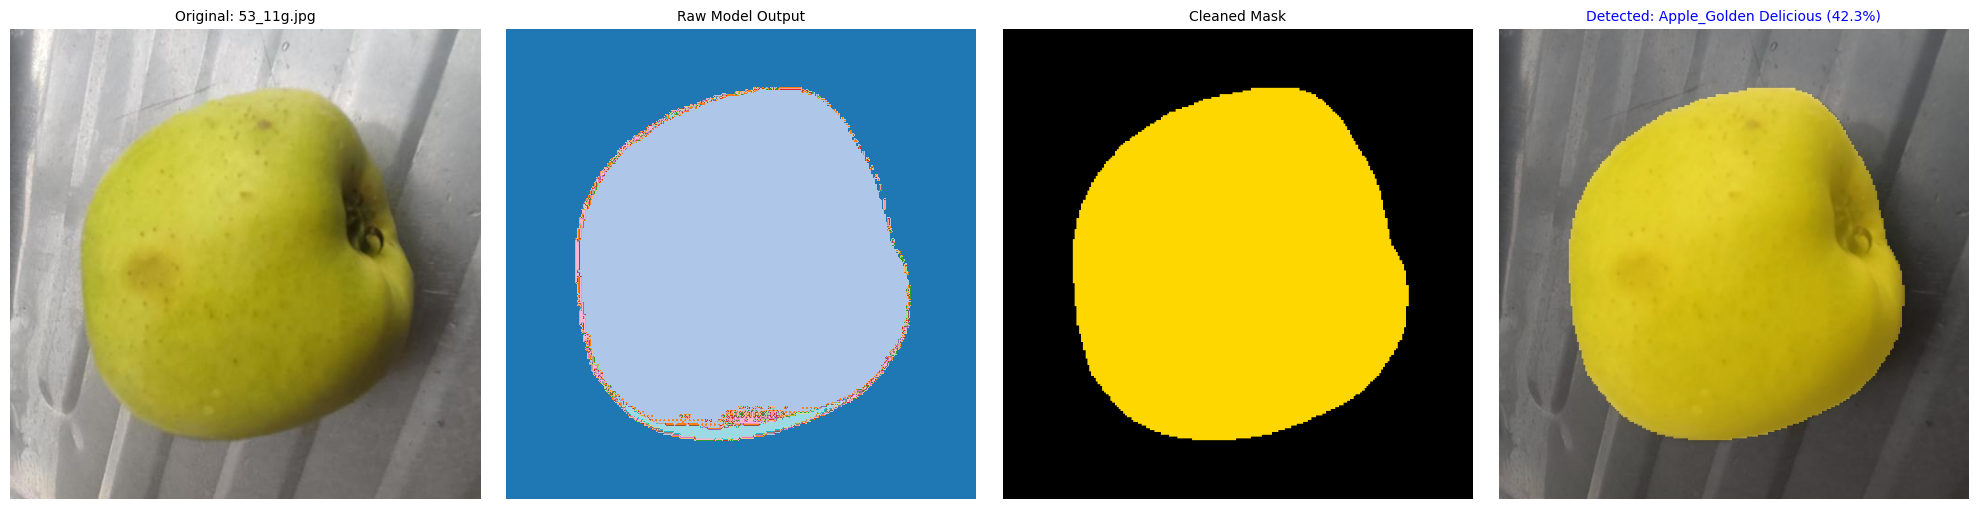

🖼️ Image: 77_11g.jpg
⏱️ Inference: 209.9ms
🍎 Detected: Banana (35.6%)
--------------------------------------------------


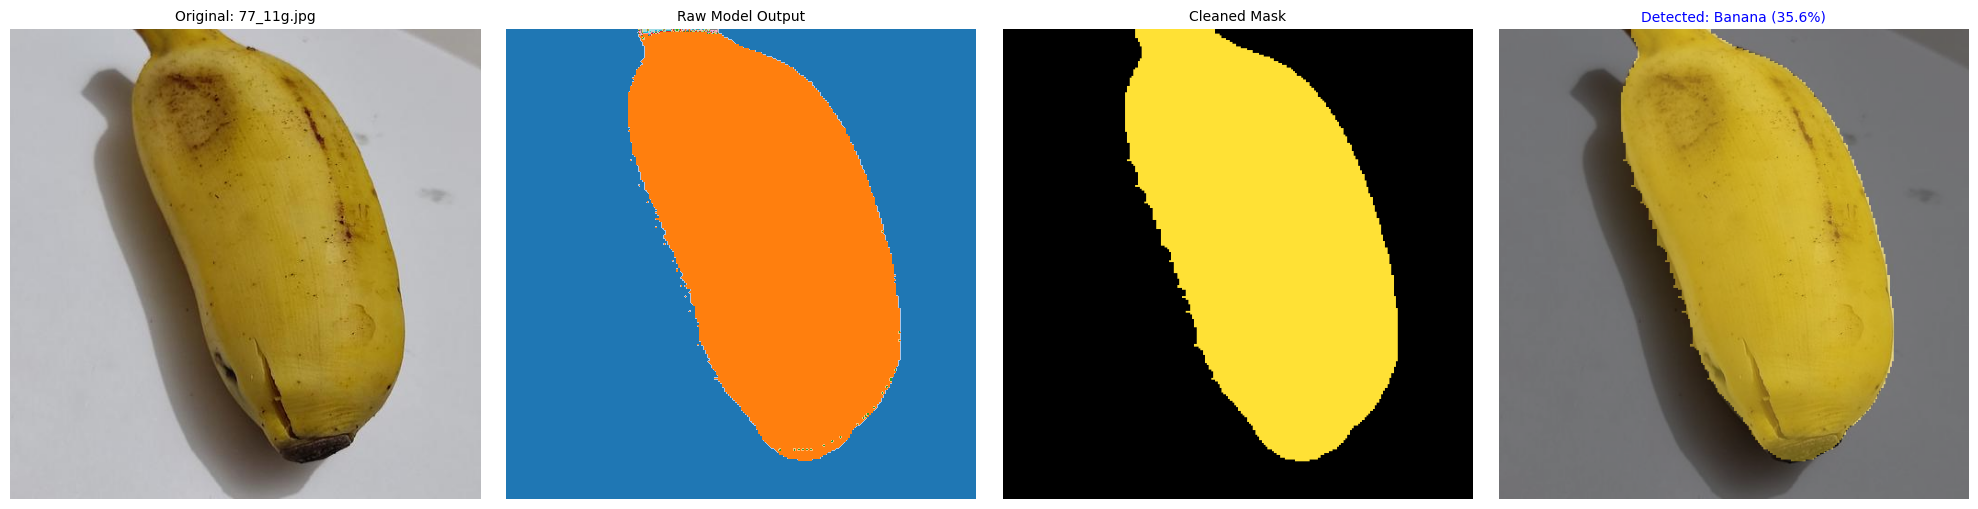

🖼️ Image: img1_100g.jpg
⏱️ Inference: 210.0ms
🍎 Detected: Green Coconut (54.3%)
--------------------------------------------------


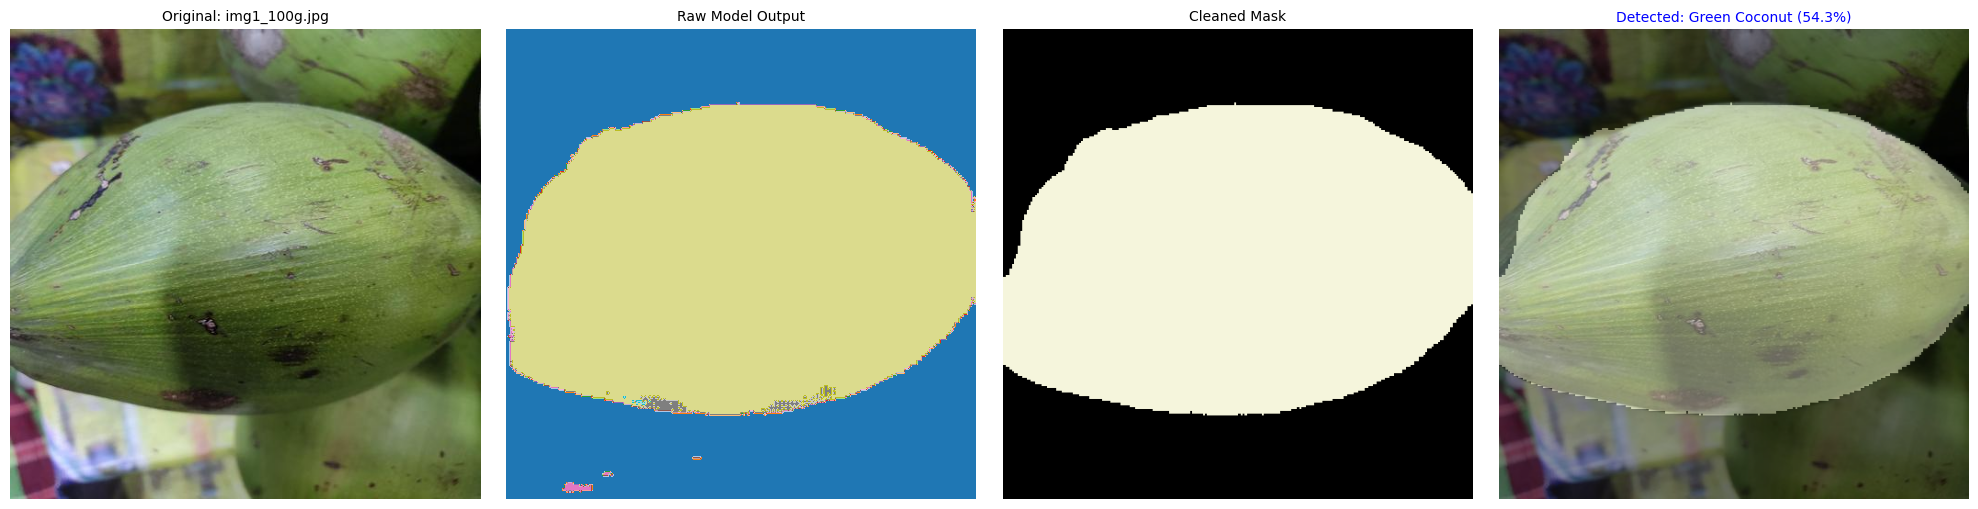

In [35]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import time
from skimage import measure
from scipy import stats
from tensorflow.keras.applications.resnet_v2 import preprocess_input

# ============================================================================
# 1. CONFIGURATION
# ============================================================================
class TestConfig:
    # Directory where your model and JSONs were saved
    OUTPUT_DIR = 'multiclass_segmentation_outputs'
    MODEL_PATH = 'Models/best_multiclass_resnet50_unet.keras'
    CLASS_MAPPING_FILE = 'Models/class_mapping.json'
    COLOR_MAPPING_FILE = 'Models/color_mapping.json'
    
    # Path to the folder containing images you want to test
    # UPDATE THIS PATH to your actual test image folder
    TEST_IMAGES_DIR = 'testA' 
    
    IMG_SIZE = 224
    NUM_CLASSES = 31  # Must match your training config

# ============================================================================
# 2. DEFINE CUSTOM OBJECTS (Required to load the model)
# ============================================================================

def dice_loss(y_true, y_pred):
    y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.cast(y_true, tf.int32)
    y_true_one_hot = tf.one_hot(y_true, depth=TestConfig.NUM_CLASSES)
    numerator = 2.0 * tf.reduce_sum(y_true_one_hot * y_pred, axis=[0, 1, 2])
    denominator = tf.reduce_sum(y_true_one_hot + y_pred, axis=[0, 1, 2])
    dice_score = (numerator + 1e-7) / (denominator + 1e-7)
    return 1.0 - tf.reduce_mean(dice_score)

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.cast(y_true, tf.int32)
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    pred_prob = tf.reduce_max(y_pred, axis=-1)
    y_pred_classes = tf.cast(tf.argmax(y_pred, axis=-1), tf.int32)
    p_t = tf.where(tf.equal(y_true, y_pred_classes), pred_prob, 1.0 - pred_prob)
    focal_weight = alpha * tf.pow((1.0 - p_t), gamma)
    focal_ce = focal_weight * ce
    return tf.reduce_mean(focal_ce)

def combined_loss(y_true, y_pred):
    ce_loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred))
    d_loss = dice_loss(y_true, y_pred)
    f_loss = focal_loss(y_true, y_pred)
    return (0.4 * ce_loss) + (0.3 * d_loss) + (0.3 * f_loss)

class MultiClassDiceCoefficient(tf.keras.metrics.Metric):
    # FIX: Added default value 'num_classes=31' to handle the missing argument
    def __init__(self, num_classes=31, name='dice_coefficient', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.total_dice = self.add_weight(name='total_dice', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.squeeze(y_true, axis=-1)
        y_pred = tf.cast(y_pred, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        
        dice_sum = 0.0
        valid_classes = 0.0
        
        for i in range(self.num_classes):
            class_idx = tf.cast(i, tf.float32)
            y_t = tf.cast(tf.equal(y_true, class_idx), tf.float32)
            y_p = tf.cast(tf.equal(y_pred, class_idx), tf.float32)
            
            inter = tf.reduce_sum(y_t * y_p)
            union = tf.reduce_sum(y_t) + tf.reduce_sum(y_p)
            present = tf.cast(tf.reduce_sum(y_t) > 0, tf.float32)
            
            dice = tf.math.divide_no_nan(2.0 * inter, union)
            dice_sum += dice * present
            valid_classes += present
            
        batch_dice = tf.math.divide_no_nan(dice_sum, valid_classes)
        self.total_dice.assign_add(batch_dice)
        self.count.assign_add(1.0)

    def result(self):
        return tf.math.divide_no_nan(self.total_dice, self.count)

    def reset_state(self):
        self.total_dice.assign(0.0)
        self.count.assign(0.0)
        
    def get_config(self):
        config = super().get_config()
        config.update({"num_classes": self.num_classes})
        return config

# ============================================================================
# 3. HELPER FUNCTIONS
# ============================================================================

def get_fruit_color(fruit_name, color_mapping):
    if fruit_name in color_mapping:
        return np.array(color_mapping[fruit_name], dtype=np.uint8)
    return np.random.randint(50, 255, size=3, dtype=np.uint8)

def clean_mask_advanced(pred_mask):
    """
    FIXED: Ensures input is a valid NumPy array before OpenCV operations
    """
    # 1. Convert Tensor to Numpy if needed
    if hasattr(pred_mask, 'numpy'):
        pred_mask = pred_mask.numpy()
    
    pred_mask = np.array(pred_mask)
    
    # 2. Binary mask (uint8)
    binary_mask = (pred_mask > 0).astype(np.uint8)
    
    # 3. Morphological closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    
    # 4. Connected Components
    labels = measure.label(binary_mask)
    cleaned_mask = pred_mask.copy()
    
    for region in measure.regionprops(labels):
        if region.area < 50: # Remove small noise
            coords = region.coords
            cleaned_mask[coords[:, 0], coords[:, 1]] = 0
            continue
            
        # Majority voting for class label
        coords = region.coords
        region_vals = pred_mask[coords[:, 0], coords[:, 1]]
        region_vals = region_vals[region_vals > 0]
        
        if len(region_vals) > 0:
            mode_result = stats.mode(region_vals, keepdims=True)
            most_frequent_class = mode_result[0][0]
            cleaned_mask[coords[:, 0], coords[:, 1]] = most_frequent_class
        
    return cleaned_mask

# ============================================================================
# 4. MAIN PREDICTION FUNCTION
# ============================================================================

def run_inference_on_folder():
    print(f"\n🚀 Loading model from: {TestConfig.MODEL_PATH}")
    
    # Load Mappings
    if not os.path.exists(TestConfig.CLASS_MAPPING_FILE):
        print("❌ Class mapping file not found!")
        return
        
    with open(TestConfig.CLASS_MAPPING_FILE, 'r') as f:
        class_mapping = json.load(f)
    with open(TestConfig.COLOR_MAPPING_FILE, 'r') as f:
        color_mapping = json.load(f)
        
    reverse_mapping = {v: k for k, v in class_mapping.items()}

    # Load Model with Custom Objects
    custom_objects = {
        'combined_loss': combined_loss,
        'dice_loss': dice_loss,
        'focal_loss': focal_loss,
        'MultiClassDiceCoefficient': MultiClassDiceCoefficient
    }
    
    try:
        model = tf.keras.models.load_model(TestConfig.MODEL_PATH, custom_objects=custom_objects)
        print("✅ Model loaded successfully!")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return

    # Get images
    if not os.path.exists(TestConfig.TEST_IMAGES_DIR):
        print(f"❌ Test directory not found: {TestConfig.TEST_IMAGES_DIR}")
        return

    image_files = [f for f in os.listdir(TestConfig.TEST_IMAGES_DIR) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    
    print(f"📊 Found {len(image_files)} images in test folder.\n")

    # Process each image
    for img_file in image_files:
        img_path = os.path.join(TestConfig.TEST_IMAGES_DIR, img_file)
        
        # 1. Read Image
        original_img = cv2.imread(img_path)
        if original_img is None: continue
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        h, w = original_img.shape[:2]
        
        # 2. Preprocess
        img_tensor = tf.convert_to_tensor(original_img)
        img_tensor = tf.image.resize(img_tensor, (TestConfig.IMG_SIZE, TestConfig.IMG_SIZE))
        img_input = preprocess_input(img_tensor)
        img_input = tf.expand_dims(img_input, axis=0)
        
        # 3. Predict (with timing)
        start_time = time.time()
        pred_probs = model.predict(img_input, verbose=0)[0]
        inference_time = (time.time() - start_time) * 1000 # ms
        
        pred_mask_raw = np.argmax(pred_probs, axis=-1)
        
        # 4. Clean Mask (The Fix Applied Here)
        pred_mask_clean = clean_mask_advanced(pred_mask_raw)
        
        # 5. Detect Fruits
        # 5. Detect Fruits (WITH FILTERING)
        detected_indices = np.unique(pred_mask_clean)
        detected_indices = detected_indices[detected_indices != 0] # Exclude background
        
        detected_fruits = []
        total_pixels = TestConfig.IMG_SIZE * TestConfig.IMG_SIZE
        
        for idx in detected_indices:
            # Count how many pixels belong to this class
            pixel_count = np.sum(pred_mask_clean == idx)
            
            # Calculate percentage of the image
            percentage = (pixel_count / total_pixels) * 100
            
            # RULE: Only accept if it covers more than 1% of the image
            if percentage > 1.0: 
                fruit_name = reverse_mapping.get(int(idx), 'Unknown')
                detected_fruits.append(f"{fruit_name} ({percentage:.1f}%)")
            else:
                # Optional: clean this noise from the mask so it doesn't show in the plot
                pred_mask_clean[pred_mask_clean == idx] = 0
        print(f"🖼️ Image: {img_file}")
        print(f"⏱️ Inference: {inference_time:.1f}ms")
        print(f"🍎 Detected: {', '.join(detected_fruits) if detected_fruits else 'None'}")
        print("-" * 50)

        # 6. Visualization Preparation
        # Create Colored Mask
        mask_colored = np.zeros((TestConfig.IMG_SIZE, TestConfig.IMG_SIZE, 3), dtype=np.uint8)
        for idx in detected_indices:
            fruit_name = reverse_mapping.get(int(idx), 'background')
            color = get_fruit_color(fruit_name, color_mapping)
            mask_colored[pred_mask_clean == idx] = color
            
        # Resize mask to original image size
        mask_resized = cv2.resize(mask_colored, (w, h), interpolation=cv2.INTER_NEAREST)
        
        # Overlay
        overlay = cv2.addWeighted(original_img, 0.6, mask_resized, 0.4, 0)
        
        # 7. Plotting
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        axes[0].imshow(original_img)
        axes[0].set_title(f"Original: {img_file}", fontsize=10)
        axes[0].axis('off')
        
        axes[1].imshow(pred_mask_raw, cmap='tab20')
        axes[1].set_title("Raw Model Output", fontsize=10)
        axes[1].axis('off')
        
        axes[2].imshow(mask_resized)
        axes[2].set_title("Cleaned Mask", fontsize=10)
        axes[2].axis('off')
        
        axes[3].imshow(overlay)
        axes[3].set_title(f"Detected: {', '.join(detected_fruits)}", fontsize=10, color='blue')
        axes[3].axis('off')
        
        plt.tight_layout()
        plt.show()

# ============================================================================
# 5. EXECUTE
# ============================================================================
if __name__ == "__main__":
    run_inference_on_folder()